In [5]:
%matplotlib inline

import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib

In [42]:
data = pd.read_csv("kddcup.data_10_percent.csv", low_memory=False)
# extract just the logged-in HTTP accesses from the data
data = data[data['service'] == "http"]  
data = data[data["logged_in"] == 1]

In [43]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


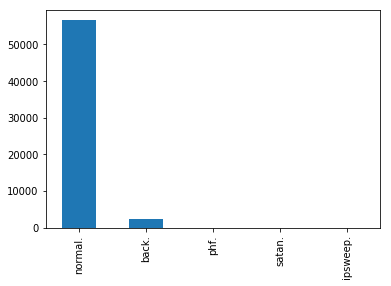

In [44]:
data.label.value_counts().plot(kind='bar')  

## Extracting and Normalizing Features

In [45]:
relevant_features = ["duration", "src_bytes", "dst_bytes", "label"]
data = data[relevant_features]

# normalize data
data["duration"] = np.log((data["duration"] + 0.1).astype(float))  
data["src_bytes"] = np.log((data["src_bytes"] + 0.1).astype(float))  
data["dst_bytes"] = np.log((data["dst_bytes"] + 0.1).astype(float))  

In [46]:
data.head()

,duration,src_bytes,dst_bytes,label
0,-2.302585,5.199049,8.603389,normal.
1,-2.302585,5.476882,6.186414,normal.
2,-2.302585,5.460011,7.198258,normal.
3,-2.302585,5.389528,7.198258,normal.
4,-2.302585,5.380358,7.616825,normal.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1359014048>,
      dtype=object)

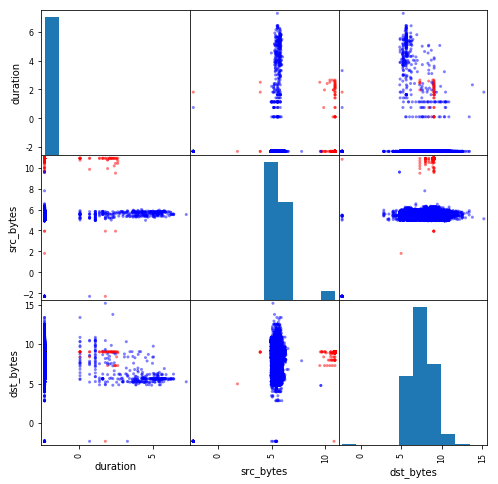

In [49]:
from pandas.plotting import scatter_matrix
colors = np.where(data['label']=='normal.', 'b', 'r')
scatter_matrix(data[["duration", "src_bytes", "dst_bytes"]], figsize=(8,8), c=colors)

## Making Data One Class

In [27]:
# class 1 (normal) and class -1 (attack)
data.loc[data['label'] == "normal.", "attack"] = 1  
data.loc[data['label'] != "normal.", "attack"] = -1

In [28]:
target = data['attack']
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

outliers.shape (2209,)
outlier fraction 0.03761600681140911


In [29]:
# drop label and attack as we are doing unsupervised learning
data.drop(['label', 'attack'], axis=1, inplace=True)
# check that shape is correct
data.shape

(58725, 3)

## Split data into training and test sets

In [38]:
from sklearn.model_selection import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  

/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(46980, 3)

## Training the Model

In [39]:
from sklearn import svm

nu = outliers.shape[0] / target.shape[0]
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=0.00005)
model.fit(train_data)

nu 0.03761600681140911


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.03761600681140911, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [40]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  0.9770966368667519
precision:  0.9987569778742061
recall:  0.9774179992480039
f1:  0.9879722781131232
area under curve (auc):  0.9731458983223608
